In [1]:
import pylab
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import pickle
import gzip

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

In [2]:

with gzip.open("../mnist.pkl.gz", "rb") as f:
    MNIST = pickle.load(f, encoding="latin1")  # or encoding="bytes"

# unpack once
(train_set, valid_set, test_set) = MNIST

# rebuild the structure the notebook assumes
MNIST = {
    "Train": {
        "Features": train_set[0],
        "Labels": train_set[1],
    },
    "Validation": {
        "Features": valid_set[0],
        "Labels": valid_set[1],
    },
    "Test": {
        "Features": test_set[0],
        "Labels": test_set[1],
    },
}

In [3]:
def set_mnist_pos_neg(positive_label, negative_label):
    positive_indices = [i for i, j in enumerate(MNIST['Train']['Labels'])
                        if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST['Train']['Labels'])
                        if j == negative_label]

    positive_images = MNIST['Train']['Features'][positive_indices]
    negative_images = MNIST['Train']['Features'][negative_indices]

    fig = pylab.figure()
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(positive_images[0].reshape(28, 28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    pylab.imshow(negative_images[0].reshape(28, 28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.show()

    return positive_images, negative_images

In [4]:
def train_graph(weights, positive_examples, negative_examples, num_iterations=100):
    if len(weights) == 0:
        num_dims = positive_examples.shape[1]
        weights = np.zeros((num_dims, 1))  # initialize weights

    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]

    report_frequency = 15

    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)

        if i % report_frequency == 0:
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            # print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

In [ ]:
cal_weights = []
for i in range(10):
    cal_weight = []
    pos_digit = i
    neg_digit = 0
    while True:
        if neg_digit == pos_digit:
            print('Skipping current digit:', neg_digit, ', because it equals pos_digit', pos_digit)
            neg_digit += 1
            continue
        if neg_digit > 9:
            break
        pos_img, neg_img = set_mnist_pos_neg(pos_digit, neg_digit)
        cal_weight = train_graph(cal_weight, pos_img, neg_img, 1000)
        neg_digit += 1
    cal_weights.append(cal_weight)

In [7]:
# Function to get a random test data point
def random_get_test_data():
    random_index = random.randint(0, len(MNIST['Test']['Features']) - 1)
    return MNIST['Test']['Features'][random_index], MNIST['Test']['Labels'][random_index]

In [8]:
# show_image function to display an image with its label
def show_image(image, label):
    fig = pylab.figure(figsize=(2, 2))
    ax = fig.add_subplot(1, 1, 1)
    pylab.imshow(image.reshape(28, 28), cmap='gray', interpolation='nearest')
    ax.set_title('Image is: ' + str(label))
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.show()

(1, 784, 10)
(1, 784)
[[[ -96.65924072 -119.85726929  108.97398376  -12.61653137   72.71076965
     91.82540894  366.55630493 -263.73834229 -127.2947998   -36.83976746]]]


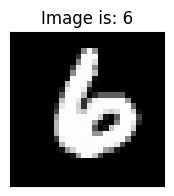

Predicted label:  6
Actual Label:  6


In [18]:
np_cal_weights = np.array(cal_weights).transpose()
print(np_cal_weights.shape)
test_image, test_label = random_get_test_data()
np_test_image = np.reshape(test_image, (1, 784))
print(np_test_image.shape)
z = np.dot(np_test_image, np_cal_weights)
print(z)
predicted_label = np.argmax(z)
show_image(test_image, test_label)
print("Predicted label: ", predicted_label)
print('Actual Label: ', test_label)

In [20]:
np_cal_weights = np.array(cal_weights).transpose()
incorrect_count = 0
incorrect_images = []
for i in range(1000):
    test_image, test_label = random_get_test_data()
    np_test_image = np.reshape(test_image, (1, 784))
    z = np.dot(np_test_image, np_cal_weights)
    predicted_label = np.argmax(z)
    if predicted_label != test_label:
        incorrect_count += 1
        incorrect_images.append([test_image, test_label])
print("Test 1000 times. The accuracy is: ", 1 - (incorrect_count / 1000))

Test 1000 times. The accuracy is:  0.5920000000000001


### AI answer

In [29]:
import numpy as np
np.random.seed(1)                       # reproducibility

# 1.  Prepare data -----------------------------------------------------------
X_train = MNIST['Train']['Features']     # (50 k, 784)
y_train = MNIST['Train']['Labels']       # (50 k,)
X_test  = MNIST['Test']['Features']
y_test  = MNIST['Test']['Labels']

# add bias and centre pixel values at 0
def add_bias_and_center(X):
    Xc = X.astype(np.float32) - 0.5      # centre
    return np.hstack([Xc, np.ones((Xc.shape[0], 1), dtype=np.float32)])

X_train_b = add_bias_and_center(X_train) # (50 k, 785)
X_test_b  = add_bias_and_center(X_test)

# 2.  Multi-class perceptron -------------------------------------------------
def train_perceptron(X, y, n_classes=10, n_epochs=10, lr=1.0):
    W = np.zeros((n_classes, X.shape[1]), dtype=np.float32)   # (10, 785)
    for epoch in range(n_epochs):
        idx = np.random.permutation(len(X))                   # shuffle
        for i in idx:
            xi = X[i]
            yi = y[i]
            scores = W @ xi
            y_pred = scores.argmax()
            if y_pred != yi:                                  # perceptron update
                W[yi] += lr * xi
                W[y_pred] -= lr * xi
    return W

def predict(W, X):
    return (X @ W.T).argmax(axis=1)

W = train_perceptron(X_train_b, y_train, n_epochs=10, lr=1.0)

# 3.  Evaluate ---------------------------------------------------------------
y_pred = predict(W, X_test_b)
acc = (y_pred == y_test).mean()
print(f"Test accuracy = {acc*100:.2f}%")


Test accuracy = 89.52%


In [33]:
def add_bias_and_center_for_one(X):
    Xc = X.astype(np.float32) - 0.5      # centre
    return np.hstack([Xc, 1])


In [32]:
np.ones((10, 1), dtype=np.float32)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [41]:
test_image, test_label = random_get_test_data()
test_image_bias = add_bias_and_center_for_one(test_image)
print(test_image_bias.shape)
print(test_image_bias.reshape(test_image_bias.shape[0], 1).shape.transpose())
print(test_image.shape[0])

(785,)


AttributeError: 'tuple' object has no attribute 'transpose'

In [44]:
incorrect_count = 0
incorrect_images = []
for i in range(1000):
    test_image, test_label = random_get_test_data()
    test_image_bias = add_bias_and_center_for_one(test_image)
    test_image_bias.reshape(test_image_bias.shape[0], 1)
    predicted_label = np.argmax(test_image_bias)
    # np_test_image = np.reshape(test_image, (1, 784))
    z = np.dot(W, test_image_bias)
    predicted_label = np.argmax(z)
    if predicted_label != test_label:
        incorrect_count += 1
        incorrect_images.append([test_image, test_label])
print("Test 1000 times. The accuracy is: ", 1 - (incorrect_count / 1000))

Test 1000 times. The accuracy is:  0.878


[-519.32839966 -547.56872559   49.59884644  164.04827881  189.94480896
  132.99295044   32.77819824  193.52958679  141.00160217  163.00285339]


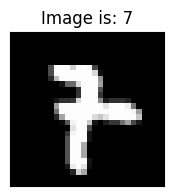

Predicted label:  7
Actual Label:  7


In [89]:
test_image, test_label = random_get_test_data()
test_image_bias = add_bias_and_center_for_one(test_image)
test_image_bias.reshape(test_image_bias.shape[0], 1)
z = np.dot(W, test_image_bias)
print(z)
predicted_label = np.argmax(z)
show_image(test_image, test_label)
print("Predicted label: ", predicted_label)
print('Actual Label: ', test_label)